In [1]:
import numpy as np
import pyshtools as pysh
from scipy import io
from scipy import interpolate
from matplotlib import pyplot as plt
import math
import time

Si il y a une erreur sur les modules : 

    - Faire clique droit --> new console for notebook
    - taper les commandes suivantes : 
        - conda install numpy
        - conda install matplotlib
        - conda install -c conda-forge pyshtools
    -Kernel --> restart kernel
    
Si un module est ajouté : conda env export -n <env-name>
    
Quand tu quitte l'env : ne pas oublier de saµuvegarder le dépôt vers Github ! (j'ai déjà perdu des données comme ça ^^) :
    -Enregistrer le fichier ! Selectionner le fichier, clique droit, download, puis push le fichier sur git. 
    

# Code to solve the elastic sea level equation following 

Kendall et al., 2005 and Austermann et al., 2015

J. Austermann 2015

Translated to Python and modified by A. Wickert, 2015

## Functions called in the main body

In [2]:
def reorder_m_to_l_primary(ml):
  # maxdeg + 1 b/c [0...maxdeg]
  lm_grid = np.nan * np.zeros((maxdeg + 1, maxdeg + 1), dtype='complex')
  j = 0
  for i in range(maxdeg + 1):
    lm_grid[i:, i] = ml[j:j+maxdeg+1-i]
    j += maxdeg + 1 - i
  lm = []
  for row in lm_grid:
    lm += list(row[np.isnan(row) == False])
  lm = np.array(lm)
  return lm

def reorder_l_to_m_primary(lm):
  # maxdeg + 1 b/c [0...maxdeg]
  ml_grid = np.nan * np.zeros((maxdeg + 1, maxdeg + 1), dtype='complex')
  j = 0
  for i in range(maxdeg + 1):
    ml_grid[i, :i+1] = lm[j:j+i+1]
    j += i+1
    #ml_grid[i, :maxdeg+1-i] = lm[j:j+maxdeg+1-i]
    #j += maxdeg + 1 - i
  ml_grid_transpose = ml_grid.transpose()
  ml = []
  for row in ml_grid_transpose:
    ml += list(row[np.isnan(row) == False])
  ml = np.array(ml)
  return ml

In [3]:
## Set up love number input

def love_lm(num, group='m'):
  """
  no dc shift also for gravity love number
  """
  num = num[:maxdeg]
  h = np.hstack(( 0, num.squeeze() ))
  h_lm = [];
  print =(group)
  if group == 'l':
    # This is the standard for Jerry's code
    for l in range(maxdeg+1):
      h_lm += ([h[l]] * (l + 1))
  elif group == 'm':
    # This works with the spherical harmonic library I am using here
    for m in range(maxdeg+1):
      h_lm += (list(h[m:]))
    # Although an analagous expression to Jerry's produces a plot that is more
    # like his...
    #for m in range(maxdeg+1):
    #  h_lm += ([h[m]] * m)
  h_lm = np.array(h_lm)
  return h_lm

In [4]:
def get_tlm(maxdeg,earth, group='l'):
  T_lm = []
  T = np.zeros(maxdeg+1)
  const = 4*np.pi*earth.a**3/earth.M_e
  if group == 'l':
    # This is the standard for Jerry's code
    for l in range(maxdeg+1):
      T[l] = const / (2 * l + 1.)
      T_lm += ([T[l]] * (l + 1)) # IMPORTANT -- must have one entry per SH order
  elif group == 'm':
    # This works with the spherical harmonic library I am using here, I think
    for m in range(maxdeg):
      T[m] = const / (2 * m)
      T_lm += (list(T[:m+1])) # IMPORTANT
  T_lm = np.array(T_lm)
  return T_lm

In [5]:
def calc_rot(L_in, _k, _k_tide, group='l'):

  # extract degree 2:
  if group == 'l':
    L20 = L_in[3]
    L21 = L_in[4] 
    L22 = L_in[5]
    print(L22)
  elif group == 'm':
    print("WARN: hard-coded max l,m; will break!")
    L20 = L_in[2]
    L21 = L_in[maxdeg+2]
    L22 = L_in[2*maxdeg + 1]
    print(L22)
  k_L = _k[1] # This has 256 values
  k_T = _k_tide[1] # This has 256 values

  I13 = sqrt_32_15 * np.pi * a**4 * np.real(L21)
  I23 = - sqrt_32_15 * np.pi * a**4 * np.imag(L21)

  II = I13 + 1j * I23

  # equation from Mitrovica and Wahr 2005

  m0 = II/CminA * (1 + k_L) / ( 1 - (k_T/k_hydro) )

  m1 = np.real(m0)
  m2 = np.imag(m0)
  m3 = 0

  m = np.hstack((m1, m2, m3))

  # calculate the perturbation to the rotational potential from Milne 1998

  La00 = a**2 * omega**2/3 * (np.sum(m**2) + 2*m3)
  La20 = a**2 * omega**2/(6*5**.5) * (m1**2 + m2**2 - 2*m3**2 - 4*m3)
  La21 = a**2 * omega**2/30**.5 * (m1*(1+m3) - 1j*m2*(1+m3))
  La22 = a**2 * omega**2/5**.5 * 24**.5 * ( (m2**2-m1**2) + 1j*2*m1*m2 )
  La2m1 = -1 * np.conj(La21)
  La2m2 = 1 * np.conj(La22)

  La_out = np.zeros(L_ml.shape, dtype=np.complex)

  if group == 'l':
    # NOTE! WILL HAVE TO CHANGE THIS if l,m are switched
    # This is written for ordering by l first, and then m (in inner loop)
    La_out[:6] += np.hstack((La00, 0, 0, La20, La21, La22))
  elif group == 'm':
    La_out[0:0+1] += La00
    La_out[2:2+1] += La20
    La_out[maxdeg+2:maxdeg+2+1] = La21 #complex(La21)
    La_out[2*maxdeg+1:2*maxdeg+1+1] += La22

  return La_out

## Earth class

In [68]:
class EARTH(object):
    """
    A class defining several Earth parameters
    """
    
    def __init__(self):
        """
        initialize the earth parameter in an object
        """
        self.rho_ice = 916.7
        self.rho_water = 1000.
        self.rho_sed = 2300.
        self.g = 9.80616
        self.M_e = 5.9742E24 # Earth mass [kg]
        # for calc_rot
        self.omega = 7.292E-5 # Earth's angular velocity
        self.k_hydro = 0.934 # degree-2 hydrostatic Love number
        self.CminA = 2.6E35 # a, c = smallest and largest principal moments of the inertia tensor
        self.sqrt_32_15 = (32/15.)**0.5
        self.a = rsphere = 6.37122e6 # earth radius
    
    def create_GRID(self,maxdeg):
        return self.GRID(maxdeg,self)
        
    class GRID(object):
        """
        A class defining several Earth parameters
        """
        def __init__(self,maxdeg,earth):
            """
            Creating the grid over wich the earth is generated
            """
            self.earth=earth
            self.maxdeg=maxdeg
            self.nlons = (maxdeg + 1 + iseven) * 2
            self.nlats = (maxdeg + 1 + iseven)
            intgrid=pysh.SHGrid.from_zeros(maxdeg, grid='GLQ', kind='real', sampling=2)
            self.lats=intgrid.lats()
            self.elons  =  intgrid.lons()
            self.colats = 90 - self.lats
            
        def create_ICE(self,way):
            return self.ICE(way,self)
        
        def create_SED(self):
            return self.SED(self)
        
        def create_TOPO(self,way):
            return self.TOPO(self,way)
        
        def create_LOVE(self,way):
            return self.LOVE(self,way)
        
        def create_OCEAN(self):
            return self.OCEAN(self)
        
        def grdtospec(self,grid):
            gridint=pysh.SHGrid.from_array(grid,'GLQ')
            grid2=gridint.expand()
            coeff=grid2.coeffs
            a=coeff[0]
            b=coeff[1]
            nmstrt=0
            out=np.zeros((int((self.maxdeg+1)*(self.maxdeg+2))))
            out.dtype='complex'
            for m in range(self.maxdeg+1):
                for n in range(m,self.maxdeg+1):
                    nm=nmstrt+n-m
                    out[nm]=1/2*complex(a[m,n],b[m,n])
                nmstrt=nmstrt+maxdeg-m+1
            return out
        
        def spectogrd(self,grid):
            gridint=pysh.SHGrid.from_array(grid,'GLQ')
            grid2=gridint.expand()
            coeff=grid2.coeffs
            ntrunc = -1.5 + 0.5*sqrt(9.-8.*(1.-float(len(data))))
            a=np.zeros((int((self.maxdeg+1),int(self.maxdeg+1))))
            b=np.zeros((int((self.maxdeg+1),int(self.maxdeg+1))))
            for m in range(self.maxdeg+1):
                for n in range(self.maxdeg+1):
                    nm=nmstrt+n-m
                    a[m,n],b[m,n]=real(out[nm]*2),np.imag(out[nm]*2)
                nmstrt=nmstrt+maxdeg-m+1
            return out

            
        class ICE(object):
            """
            A class defining several Earth parameters
            """
            def __init__(self,way,grid):
                """
                Creating the grid over wich the earth is generated
                """
                ice=io.loadmat(way)
                f = interpolate.interp2d(ice['lon_WAIS'][0,:],ice['lat_WAIS'][:,0], ice['ice_Ant'])
                self.ice_0 = f(grid.elons, grid.lats)

                f = interpolate.interp2d(ice['lon_WAIS'][0,:],ice['lat_WAIS'][:,0], ice['ice_EAIS'])
                self.ice_j = f(grid.elons, grid.lats)

                self.del_ice = self.ice_j - self.ice_0
    
        class SED(object):
            """
            A class defining several Earth parameters
            """
            def __init__(self,grid):
                self.del_sed=np.zeros((grid.nlats,grid.nlons))
                
        class TOPO(object):
            """
            A class defining several Earth parameters
            """
            def __init__(self,grid,way):
                topo = io.loadmat(way)
                topo_nlats, topo_nlons = topo['map_data'].shape
                topo_colats = np.linspace(180./topo_nlats/2., 180 - 180./topo_nlats/2., topo_nlats)
                topo_elons = np.linspace(360./topo_nlons/2., 360 - 360./topo_nlons/2., topo_nlons)
                f = interpolate.interp2d(topo_elons, topo_colats, topo['map_data'])
                self.topo0 = f(grid.elons[0:-1],grid.colats)
                temp=np.zeros((self.topo0.shape[0],self.topo0.shape[1]+1))
                temp[:,0:-1]=self.topo0
                temp[:,-1]=self.topo0[:,0]
                self.topo0=temp
            
        class LOVE(object):
            """
            A class defining several Earth parameters
            """
            def __init__(self,grid,way):
                love = io.loadmat('prem.l90.VM2_512')
                self.h_lm = love_lm(love['h_el'])
                self.k_lm = love_lm(love['k_el'])
                self.h_lm_tide = love_lm(love['h_el_tide'])
                self.k_lm_tide = love_lm(love['k_el_tide'])
                self.E_ml = 1 + self.k_lm - self.h_lm
                self.T_lm = get_tlm(maxdeg,grid.earth)
                self.T_ml = reorder_l_to_m_primary(self.T_lm)
                self.E_ml_T = 1 + self.k_lm_tide - self.h_lm_tide
                
        class OCEAN(object):
            """
            A class defining several Earth parameters
            """
            def __init__(self,grid):
                self.oc=np.zeros((grid.nlats,grid.nlons))
            
            def topotoocean(self,ingrid):
                out = -0.5*np.sign(ingrid)+0.5
                out = 0.5*np.sign(out-0.6)+0.5
                return out
                

## Parameters & Inputs

### Specify the earth parameters

In [69]:
# Specify maximum degree to which spherical transformations should be done
# Optimized to work at degree (2**n - 1), where n is a positive integer
maxdeg = 63 # N
iseven = (maxdeg % 2 == 0)

earth=EARTH()

# grid info
grid=earth.create_GRID(maxdeg)

setup up spherical harmonic instance, set lats/lons of grid

See Mitrovica et al. (2005) and Milne and Mitrovica (1998)

### Define Ice sheet

interpolate ice masks on common grid

Consider RectBivariateSpline

In [70]:
ice=grid.create_ICE('WAIS')
ice_j=ice.ice_j
print(ice.del_ice.shape)

(64, 128)


### Define dynamic topography

In [71]:
#peut être à virer ? 
del_DT = np.zeros(ice.del_ice.shape)

### Define Sediment

In [72]:
sed = grid.create_SED()

### Define Topography

load preloaded topo (including ice) as topo_orig, lon_topo, lat_topo

In [73]:
topo = grid.create_TOPO('gebco_08_15am')

interpolate topography grid onto Gauss Legendre Grid

### Define love numbers

prepare love numbers in suitable format and calculate T_lm and E_lm to calculate the fluid case, switch h_el to h_fl, k_el to k_fl and same for tidal love numbers

1 value per degree -- but not per degree and order!

k is gravity field deformation Love number (G)

h is the solid Earth deformation Love number (R)

In [74]:
love=grid.create_LOVE('prem.l90.VM2_512')

## Solve sea level equation

(after Kendall 2005, Dalca 2013 & Austermann et al. 2015)

### Loop criterion

In [75]:
k_max = 10   # maximum number of iterations
epsilon = 10**-4 # convergence criterion

### Initialize the different parameters

Setup topography and ocean function at present day

In [76]:
topo_0 = topo.topo0.copy(); # already includes ice and dynamic topography
ocean=grid.create_OCEAN()
oc_0 = ocean.topotoocean(topo_0)

Set up topography and ocean function after the ice change

In [77]:
topo_j = topo_0 + ice.del_ice; # del_ice is negative -> subtract ice that is melted
oc_j = ocean.topotoocean(topo_j)

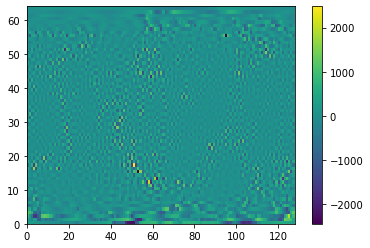

In [84]:
topot=pysh.SHGrid.from_array(topo_0,'GLQ').expand().expand('GLQ').to_array()
plt.pcolor(topot-topo_0)
plt.colorbar()
plt.show()

calculate change in sediments and decompose into spherical harmonics both sediment and ocean function

In [78]:
sed.Sed_ml = grid.grdtospec(sed.del_sed)
oc0_ml = grid.grdtospec(oc_0)

### Define initial values so we don't exit while loop

In [79]:
k = 0
chi = epsilon * 2
start_time = time.time()
# Iterations k
# Iteration criterion epsilon

### Main loop

In [18]:
while (k < k_max) and (chi >= epsilon):
  # expand ocean function into spherical harmonics in m-first ordering
  ocj_ml = grid.grdtospec(oc_j)
  # CHECK ICE MODEL 
  # check ice model for floating ice
  check1 = ocean.topotoocean(-topo_j + ice_j)
  check2 = ocean.topotoocean(+topo_j - ice_j) * \
    (topo.topotoocean(-ice_j*rho_ice - (topo_j - ice_j)*earth.rho_water))
  
  # Applying the floating ice correction
  del_ice_corrected = ice_j - ice_0
  deli_ml = grid.grdtospec(del_ice_corrected)
  
  # calculate topography correction, shoreline migration
  TO = topo_0 * (oc_j-oc_0)
  # expand TO function into spherical harmonics
  TO_ml = grid.grdtospec(TO)
  
  # set up initial guess for sea level change
  if k == 0:
    # initial guess of sea level change is just to distribute the ice over the oceans uniformally
    # (remember, harmonic (0,0) is the mean)
    delS_ml = ocj_ml/ocj_ml[0]*(-earth.rho_ice/earth.rho_water*deli_ml[0] +TO_ml[0])
    # convert into spherical harmonics
      
  # calculate loading term
  # ice, water, and sediment
  L_ml = earth.rho_ice*deli_ml + earth.rho_water*delS_ml + earth.rho_sed*Sed_ml

  # calculate contribution from rotation 
  La_ml = calc_rot(L_ml, love['k_el'], love['k_el_tide'], 'm')

  # calculate sea level perturbation
  # add ice and sea level and multiply with love numbers
  # (note: this is curly L from Kendall et al. (2005), and has nothing to 
  #  do with the mathematical curl)
  delSLcurl_ml_fl = E_ml * T_ml * (earth.rho_ice*deli_ml + earth.rho_water*delS_ml \
                                   + earth.rho_sed*Sed_ml) + 1./earth.g*E_ml_T * La_ml

  # convert to spherical harmonics and subtract terms that are part
  # of the topography to get the 'pure' sea level change
  delSLcurl_fl = sh.spectogrd( delSLcurl_ml_fl, norm='unity')
  delSLcurl = delSLcurl_fl - del_ice_corrected - del_DT - del_sed


  # compute and decompose RO
  RO = delSLcurl * oc_j
  RO_ml = sh.grdtospec(RO, norm='unity')

  # calculate eustatic sea level perturbation (delta Phi / g)
  delPhi_g = 1/ocj_ml[0] * (- rho_ice/rho_water*deli_ml[0] \
      - RO_ml[0] + TO_ml[0])

  # calculate overall perturbation of sea level over oceans (spatially varying field and constant offset)
  delSL = delSLcurl + delPhi_g

  # update topography and ocean function
  topo_j = - delSL + topo_0
  oc_j = sign_01(topo_j)

  # calculate change in ocean height and decompose
  delS_new = np.real(delSL) * np.real(oc_j) -  topo_0 * (np.real(oc_j)-oc_0)
  delS_ml_new = sh.grdtospec(delS_new, norm='unity')

  # calculate convergence criterion chi
  chi = np.abs( (np.sum(np.abs(delS_ml_new)) - np.sum(np.abs(delS_ml))) \
        / np.sum(np.abs(delS_ml)) )
        
  # update sea surface height
  delS_ml = delS_ml_new.copy() # check if needed!!!!!!!
        
  k += 1



AttributeError: 'TOPO' object has no attribute 'topotoocean'

### Convergence criterion

In [19]:
if chi < epsilon:
  print('Converged after iteration', k, 'Chi was', chi)
else:
  print ('Did not yet converge.')
  print ('Finished iteration', k, '; Chi was', chi)

end_time = time.time()

print ("Time elapsed in k loop", end_time - start_time)
# calculate the scaling to normalize the fingerprint (it's normalized to be
# one on average, when averaged over the final ocean basin). 
# calculate change in sea level over final ocean basin
del_scaling = (delSL + del_ice_corrected) * oc_j
# get the average of that when spreading the water over the whole globe
sca = sh.grdtospec(del_scaling, norm='unity')
# get the average of that when spreading the water only over the oceans.
scaling_fact = sca[0] / ocj_ml[0]

Did not yet converge.
Finished iteration 0 ; Chi was 0.0002
Time elapsed in k loop 1.590588092803955


NameError: name 'delSL' is not defined

## Plot Result

In [51]:
## Plot results

# We only want the sea level change cause by melted ice, so subtract
# del_ice
SL_change_rot = delSL + del_ice_corrected
# normalize it by the scaling factor
plotSL = SL_change_rot/scaling_fact

# plot
plt.figure
plt.imshow(np.real(plotSL))
plt.colorbar()
plt.savefig('fig.eps')
plt.show()

NameError: name 'delSL' is not defined